<a id='top'></a>
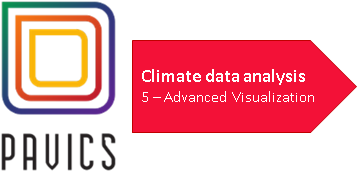

This tutorial outlines steps for visualizing and summarizing an ensemble of climate simulations into more understandable and usable representations. While tutorials up to this point have shown numerous examples of creating plots and figures from our climate data, this notebook will focus on the use of more sophisticated tools for the creation of interactive plots and tables directly in the jupyter environment through the use of the <a href="https://holoviz.org/" target="_blank">holoviz</a> ecosystem. These types of summary workflows and representations, often used on climate change information portals such as Ouranos' <a href="https://www.ouranos.ca/climate-portraits/#/" target="_blank">climate portraits</a> or the canada-wide scale <a href="https://climatedata.ca/" target="_blank">climatedata.ca</a>, include:

* [Maps of climate normals](#maps)
* [Time-series plots](#timeseries)
* [Table summaries](#tables)

Advanced topics:
* [Interactive dashboarding](#advanced)




<div class="alert alert-info"> <strong>Info!</strong> This notebook accesses files created in tutorial 3. Be sure to run the <strong>advanced</strong> section of the <strong>climate indicator calculation</strong> tutorial before beginning.
</div>
<div class="alert alert-info">
To conserve any modifications to tutorial notebooks in the PAVICS JupyterLab they need to be copied into your <a href=#workspace>writable-workspace</a> directory.    
</div>

## Ensemble dataset preparation
We will re-use the concepts of the ensembles tutorial in a slightly more complex way to prepare a dataset containing climate indicator output for both of our variables as well as including both SSP2-4.5 and SSP3-7.0 simulations.  


Addtional steps:
* Use of the <a href="https://xscen.readthedocs.io/en/stable/" target="_blank">**xscen**</a> package for :
    * Calculating 30 year <a href="https://xscen.readthedocs.io/en/stable/apidoc/xscen.html#xscen.aggregate.climatological_mean" target="_blank">**climatologies**</a>
    * Calculation regional or <a href="https://xscen.readthedocs.io/en/stable/apidoc/xscen.html#xscen.aggregate.spatial_mean" target="_blank">**spatial averages**</a>
    * <a href="https://xscen.readthedocs.io/en/stable/apidoc/xscen.html#xscen.utils.unstack_dates" target="_blank">**Unstacking**</a> the time dimension of our data (allows easier combination of both seasonal and annual results)


<div class="alert alert-warning"> <strong>Info!</strong> <a href="https://xscen.readthedocs.io/en/stable/" target="_blank"><strong>xscen</strong></a> is a climate change data analysis framework that integrates many of the tools used in PAVICS tutorials into a single package. Its main focus is the creation of reproducible workflows which could reimplement most steps in these introductory lessons.  The focus has been to look at individual modules and processing steps one by one, but `xscen` could eventually prove useful for users looking for streamlined approaches or tools.
</div>

*[return to top of page](#top)*

In [ ]:
# NBVAL_IGNORE_OUTPUT
import logging
import warnings
from pathlib import Path

import cartopy.crs as ccrs
import hvplot.pandas
import hvplot.xarray
import numpy as np
import pandas as pd
import panel as pn
import xarray as xr
import xscen as xs
from bokeh.models.tools import HoverTool
from clisops.core import subset
from IPython.display import clear_output
from xclim import ensembles as xens
from xclim.core import units

logging.getLogger().disabled = True
warnings.simplefilter("ignore")
pn.extension()

clear_output()

# Sub function definitions
output = "/notebook_dir/writable-workspace/tmp/tutorial3/output"
infolder = Path(output)
ds_all = []
for scen in ["ssp245", "ssp370"]:
    ds_vars = []
    for v in ["tx_mean", "tx_days_above_27"]:
        for f in ["seasonal", "annual"]:
            # create a list of datasets for which the time dimension has been "unstacked"
            ncfiles = [
                xs.utils.unstack_dates(xr.open_dataset(d, decode_timedelta=False))
                for d in infolder.glob(f"{v}*{f}*{scen}*.nc")
            ]

            # Create an ensemble dataset from the simulations for the given SSP
            # Add a new scen dimension and corodinate
            ds_vars.append(
                xens.create_ensemble(ncfiles, calendar="standard").expand_dims(
                    scen=[scen]
                )
            )
    # Create a single dataset with both variables
    ds_all.append(xr.merge(ds_vars))

# concatenate the 2 SSP datasets together along the new 'scen' dim
ds_ens = xr.concat(ds_all, dim="scen")
ds_ens = ds_ens.sel(time=slice("1981", "2100"))  # select years 1971-2100

# It is usually more intuitive to visualize temperature in Celsius
for v in ds_ens.data_vars:
    if units.units2pint(ds_ens[v]) == "kelvin":
        ds_ens[v] = units.convert_units_to(ds_ens[v], "degC")

# rearrange season order to something more logical
ds_ens = ds_ens.sel(season=["annual", "DJF", "MAM", "JJA", "SON"])

ds_ens

<a id='maps'></a>
___
## Maps of climate normals
In this section we examine steps to create an interactive map of 30 year climatologies. 
* First we calculate 30 year averages for the individual realizations in our ensemble dataset
* We subsequently add a delta change calculation with respect to a reference period. 
* We then calculate ensembles percentiles on the 30 year normals. 
* Finally we employ <a href="https://holoviz.org/" target="_blank">holoviz</a> tools to create an interactive figure to explore the data. 

*Remember the importance of calculating ensemble percentiles as a last step (see [notes](#notes)).*

*[return to top of page](#top)*

In [2]:
# NBVAL_IGNORE_OUTPUT
# create 30 year climate normals for the period 1981-2100
interv = 10  #  # only keep one every 10 years : 1981-2010, 1991-2020, ... 2071-2100
per = [1981, 2100]

# Calculate 30year means
ds30yAvg = xs.aggregate.climatological_mean(
    ds_ens, window=30, interval=interv, min_periods=29, periods=per
)

# Calculte delta change wrt to the 1991-2020 period
ds_delta = xs.aggregate.compute_deltas(ds=ds30yAvg, reference_horizon="1991-2020")

# combine absolute and detla back into a single dataset
ds30yAvg = xr.merge([ds30yAvg, ds_delta])
ds30yAvg

# Calculate percentiles on 30y normals
ds30yAvg_ensperc = xens.ensemble_percentiles(ds30yAvg, split=False).load()
ds30yAvg_ensperc

<xarray.Dataset>
Dimensions:                           (rlat: 22, rlon: 24, season: 5, scen: 2,
                                       time: 10, percentiles: 3)
Coordinates:
  * rlat                              (rlat) float32 -7.29 -7.2 ... -5.49 -5.4
  * rlon                              (rlon) float32 376.4 376.4 ... 378.3 378.4
  * season                            (season) object 'annual' 'DJF' ... 'SON'
  * scen                              (scen) <U6 'ssp245' 'ssp370'
    rotated_pole                      float32 9.969e+36
    lon                               (rlat, rlon) float32 -67.76 ... -63.81
    lat                               (rlat, rlon) float32 47.94 47.91 ... 48.9
    horizon                           (time) <U9 '1981-2010' ... '2071-2100'
  * time                              (time) object 1981-01-01 00:00:00 ... 2...
  * percentiles                       (percentiles) int64 10 50 90
Data variables:
    tx_mean                           (time, scen, season, rlat, rlon, percentiles) float64 ...
    tx_days_above_27                  (time, scen, season, rlat, rlon, percentiles) float64 ...
    tx_mean_delta_1991_2020           (time, scen, season, rlat, rlon, percentiles) float64 ...
    tx_days_above_27_delta_1991_2020  (time, scen, season, rlat, rlon, percentiles) float64 ...
Attributes: (12/91)
    bias_adjustment:                 DetrendedQuantileMapping(group=Grouper(n...
    cell_measures:                   area: areacella
    cell_methods:                    time: maximum within days time: mean ove...
    comment:                         maximum near-surface (usually, 2 meter) ...
    grid_mapping:                    rotated_pole
    history:                         [2023-03-28 12:26:23] regridded with arg...
    ...                              ...
    terms_of_use:                    In addition to the provided licence, the...
    attribution:                     Use of this dataset should be acknowledg...
    modeling_realm:                  atmos
    source_institution:              MPI-M
    crs:                             EPSG:4326
    cat:processing_level:            climatology

Mapping : **ESPO-G6-R2** data is on a rotated pole projection
* use the `rotated_pole` variable information to create a map that displays properly 

In [3]:
# NBVAL_IGNORE_OUTPUT
rotp = ccrs.RotatedPole(
    pole_longitude=ds30yAvg_ensperc.rotated_pole.grid_north_pole_longitude,
    pole_latitude=ds30yAvg_ensperc.rotated_pole.grid_north_pole_latitude,
)


map1 = ds30yAvg_ensperc.swap_dims({"time": "horizon"}).tx_mean.hvplot.quadmesh(
    x="rlon",
    y="rlat",
    cmap="Spectral_r",
    geo=True,
    crs=rotp,
    tiles="EsriImagery",
    framewise=False,
    frame_width=400,
    alpha=0.8,
)
map1

:DynamicMap   [percentiles,horizon,scen,season]
   :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .QuadMesh.I :QuadMesh   [rlon,rlat]   (tx_mean)

___
<a id='timeseries'></a>
### Regional averaging and time-series graphs
Here we employ tools to create time series graphs for a number of sub-regions of interest. We first calculate the proportion of individual gridcells intersecting each sub-region in order to calculate a weighted average of conditions for each sub-region.  *Remember the importance of calculating ensemble percentiles as a last step (see [notes](#notes))*
  


*[return to top of page](#top)*

In [4]:
# NBVAL_IGNORE_OUTPUT
import geopandas as gpd
import hvplot.pandas

inpoly = "/notebook_dir/pavics-homepage/tutorial_data/gaspesie_mrc.geojson"

regmean = {"name": "GaspesieMRC", "method": "shape", "shape": inpoly}

gdf = gpd.GeoDataFrame.from_file(inpoly)

reg_ds = xs.aggregate.spatial_mean(
    ds_ens.chunk({"rlat": -1, "rlon": -1}),
    method="xesmf",
    region=regmean,
    kwargs={"skipna": True},
)

# use split=True in due to hvplot.area plot methods requiring two y variables
reg_ds_ensperc = xens.ensemble_percentiles(reg_ds, split=True)


# NBVAL_IGNORE_OUTPUT

# We will use only tx_mean percentile variables for this plot
vars1 = [v for v in reg_ds if "tx_mean" in v][0]
clear_output()
# plot a simple map of the sub-regions
display(
    gdf.hvplot(
        geo=True,
        color="MUS_NM_MRC",
        tiles="EsriImagery",
        legend=False,
        frame_width=400,
    )
)


# Interative time-series plot of regional means
plt1 = reg_ds_ensperc.swap_dims({"geom": "MUS_NM_MRC"}).hvplot.area(
    groupby=["MUS_NM_MRC", "scen", "season"],
    width=800,
    height=300,
    x="time",
    y=f"{vars1}_p10",
    y2=f"{vars1}_p90",
    color="r",
    alpha=0.3,
    line_alpha=0.1,
) * reg_ds_ensperc[f"{vars1}_p50"].swap_dims({"geom": "MUS_NM_MRC"}).hvplot.line(
    groupby=["MUS_NM_MRC", "scen", "season"],
    x="time",
    color="r",
    title="time series of regional mean conditions",
)
plt1

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (MUS_NM_MRC)

:DynamicMap   [MUS_NM_MRC,scen,season]
   :Overlay
      .Area.I  :Area   [time]   (tx_mean_p10,tx_mean_p90)
      .Curve.I :Curve   [time]   (tx_mean_p50)

<a id='tables'></a>
## Summary tables
Here we produce a summary table of regional 30 year means for all variables and horizons. 
* Start with our `ds30yAvg` dataset
* Apply spatial averaging as in for the timeseries example

*Remember the importance of calculating ensemble percentiles as a last step (see [notes](#notes))*


*[return to top of page](#top)*

In [5]:
# NBVAL_IGNORE_OUTPUT
# Spatial averages on 30y means
reg_ds30y = xs.aggregate.spatial_mean(
    ds30yAvg.chunk({"rlat": -1, "rlon": -1}),
    method="xesmf",
    region=regmean,
    kwargs={"skipna": True},
)


# Ensemble percentiles
reg_ds30y_ensperc = xens.ensemble_percentiles(reg_ds30y)


# make the 'horizon' field the index of our table. rename the 'geom' field to 'region'
df = (
    reg_ds30y_ensperc.swap_dims(dict(time="horizon"))
    .drop_vars("rotated_pole")
    .to_dataframe()
)

df.hvplot.table(
    title="Summary table", fit_columns=False, sortable=True, selectable=True, width=1000
)

:Table   [horizon,scen,season,geom,tx_mean_p10,tx_mean_p50,tx_mean_p90,time,lon,lat,MUS_NM_MRC,tx_days_above_27_p10,tx_days_above_27_p50,tx_days_above_27_p90,tx_mean_delta_1991_2020_p10,tx_mean_delta_1991_2020_p50,tx_mean_delta_1991_2020_p90,tx_days_above_27_delta_1991_2020_p10,tx_days_above_27_delta_1991_2020_p50,tx_days_above_27_delta_1991_2020_p90]

<a id='advanced'></a>
___
## Advanced examples

In this section use additional steps in order to completely reproduce Ouranos' <a href="https://portraits.ouranos.ca/en/" target="_blank">Climate Portraits</a> website visualizations but using user-defined regions and our previously calculated custom climate indicators. Addtional analysis steps include:

1. Masking and subsequent <a href="https://xscen.readthedocs.io/en/stable/apidoc/xscen.html#xscen.utils.unstack_dates" target="_blank">**infilling**</a> of water body gridcells  in **ESPO-G6-R2** climate indicator output (see <a href="https://portraits.ouranos.ca/en/sources?e=CMIP6&src=espog" target="_blank">masking of water bodies</a> section for details)

2. Smoothing of time-series ensemble percentiles graphs using a moving window 


*[return to top of page](#top)*


### 1) Masking water bodies
The CaSR v2.1 (previously called RDRS) reference datset used in the ESPO-G6-R2 bias-adjustment procedure covers both land surface, as well as oceans and lakes. As such, climate conditions at the surface of large bodies of water can often be quite different from that above land, even when comparing adjacent points. This influence is mirrored in ESPO-G6-R2 grid cells containing large fractions of water. As users are typically concerned about land conditions, data for those grid cells containing a relatively high proportion of water can oftentimes misrepresent the actual climate users are interested in.  This effect can be particularly apparent in threshold climate indicators calculation (e.g. `tx_days_above_27`)



* To address this we can use the ESPO-G6-R2 land fraction mask `sftlf` to mask gridcells with less than 75% land
* For mapping data : <a href="https://xscen.readthedocs.io/en/stable/apidoc/xscen.html#xscen.spatial.creep_fill" target="_blank">Infill</a> masked cells using neighboring data



In [6]:
from siphon.catalog import TDSCatalog

url = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/datasets/simulations/bias_adjusted/cmip6/ouranos/ESPO-G/ESPO-G6-R2v1.0.0/catalog.xml"  # TEST_USE_PROD_DATA
# The mask is identical for all ESPO-G6-R2 members .. take the first ncml
espo_land = xr.open_dataset(TDSCatalog(url).datasets[0].access_urls["OPENDAP"]).sftlf
# select the same coords as our data
land_reg = espo_land.sel(rlon=ds30yAvg_ensperc.rlon, rlat=ds30yAvg_ensperc.rlat)

# simple mask of 30year data
with xr.set_options(keep_attrs=True):
    ds30yAvg_ensmask = ds30yAvg_ensperc.where(land_reg > 0.75)
    # Infill mapping data
    w = xs.spatial.creep_weights(land_reg > 0.75, n=1)
    ds30yAvg_ensfill = xs.spatial.creep_fill(ds30yAvg_ensmask, w)

    # sometimes infilling will extend non null data beyond the orginal data : mask to original
    mask_orig = ~np.isnan(
        ds30yAvg_ensperc.tx_mean.isel(time=1, scen=0, season=0, percentiles=1)
    )
    ds30yAvg_ensfill = ds30yAvg_ensfill.where(mask_orig)
ds30yAvg_ensfill = ds30yAvg_ensfill.assign_coords(ds30yAvg_ensperc.coords)


## regional average data using a mask
reg_ds = xs.aggregate.spatial_mean(
    ds_ens.where(land_reg > 0.75).chunk({"rlat": -1, "rlon": -1}),
    method="xesmf",
    region=regmean,
    kwargs={"skipna": True},
)

# regional summary data using the mask
# Spatial averages on 30y means
reg_ds30y = xs.aggregate.spatial_mean(
    ds30yAvg.where(land_reg > 0.75).chunk({"rlat": -1, "rlon": -1}),
    method="xesmf",
    region=regmean,
    kwargs={"skipna": True},
)
reg_ds30y

# Ensemble percentiles Summary data
reg_ds30y_ensperc = xens.ensemble_percentiles(reg_ds30y).swap_dims(
    {"geom": "MUS_NM_MRC"}
)
reg_ds30y_ensperc

# make the 'horizon' field the index of our table. rename the 'geom' field to 'region'
df = (
    reg_ds30y_ensperc.swap_dims(dict(time="horizon"))
    .drop_vars("rotated_pole")
    .to_dataframe()
)

# Compare original vs masked & infilled mapping data
(
    land_reg.hvplot.quadmesh(
        title="Land Fraction",
        x="rlon",
        y="rlat",
        crs=rotp,
        geo=True,
        cmap="cet_CET_L10",
        tiles="EsriImagery",
        frame_width=300,
        alpha=0.95,
    )
    + ds30yAvg_ensperc.tx_days_above_27.hvplot.quadmesh(
        title="Original : days above 27 degC",
        x="rlon",
        y="rlat",
        crs=rotp,
        geo=True,
        cmap="spectral_r",
        tiles="EsriImagery",
        frame_width=300,
        alpha=0.95,
    )
    + ds30yAvg_ensfill.tx_days_above_27.hvplot.quadmesh(
        title="Masked+Filled :  days above 27 degC",
        x="rlon",
        y="rlat",
        crs=rotp,
        geo=True,
        cmap="spectral_r",
        tiles="EsriImagery",
        frame_width=300,
        alpha=0.95,
    )
)

:Layout
   .Overlay.I     :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .QuadMesh.I :QuadMesh   [rlon,rlat]   (sftlf)
   .DynamicMap.I  :DynamicMap   [percentiles,time,scen,season]
      :Overlay
         .WMTS.I     :WMTS   [Longitude,Latitude]
         .QuadMesh.I :QuadMesh   [rlon,rlat]   (tx_days_above_27)
   .DynamicMap.II :DynamicMap   [percentiles,time,scen,season]
      :Overlay
         .WMTS.I     :WMTS   [Longitude,Latitude]
         .QuadMesh.I :QuadMesh   [rlon,rlat]   (tx_days_above_27)

### 2) Smoothing of time-series graphs 
Combine data from all realizations in a centered 30 year moving window before calculating ensemble percentiles for individual years
* Rename the `realization` to `member` as we will need to create a new combined dimension with this name in step three. 
* Use `xr.rolling` and associated `construct` method to add a new `window` dimension to our dataset
* Use `xr.stack` to combine `member` and `window` into a new `realization` dimension
* Calculate `xclim.ensemble.ensemble_percentiles` as before but now annual percentile values are calculated using `n=420` values (30 years * 14 realizations) instead of `n=14` 
  

In [7]:
# original ensemble percentiles
reg_ds_ensperc_nosmoothing = xens.ensemble_percentiles(reg_ds, split=True).swap_dims(
    {"geom": "MUS_NM_MRC"}
)

## smoothed ensemble percentiles
reg_ds_ensperc = (
    reg_ds.rename({"realization": "member"})
    .rolling(time=30, center=True)
    .construct("window")
    .stack(realization=["member", "window"])
)
reg_ds_ensperc = (
    xens.ensemble_percentiles(reg_ds_ensperc).swap_dims({"geom": "MUS_NM_MRC"}).load()
)

# Compare original vs masked & infilled mapping data
# Interative time-series plot of regional means
vars1 = [v for v in reg_ds if "tx_mean" in v][0]
plt_smoothed = reg_ds_ensperc.hvplot.area(
    groupby=["MUS_NM_MRC", "scen", "season"],
    width=500,
    height=300,
    x="time",
    y=f"{vars1}_p10",
    y2=f"{vars1}_p90",
    color="r",
    alpha=0.3,
    line_alpha=0.1,
) * reg_ds_ensperc[f"{vars1}_p50"].hvplot.line(
    groupby=["MUS_NM_MRC", "scen", "season"],
    x="time",
    color="r",
    title="Smoothed : time series",
)

plt_orig = reg_ds_ensperc_nosmoothing.hvplot.area(
    groupby=["MUS_NM_MRC", "scen", "season"],
    width=500,
    height=300,
    x="time",
    y=f"{vars1}_p10",
    y2=f"{vars1}_p90",
    color="r",
    alpha=0.3,
    line_alpha=0.1,
) * reg_ds_ensperc_nosmoothing[f"{vars1}_p50"].hvplot.line(
    groupby=["MUS_NM_MRC", "scen", "season"],
    x="time",
    color="r",
    title="Unsmoothed : time series",
)
plt_orig + plt_smoothed

:Layout
   .DynamicMap.I  :DynamicMap   [MUS_NM_MRC,scen,season]
      :Overlay
         .Area.I  :Area   [time]   (tx_mean_p10,tx_mean_p90)
         .Curve.I :Curve   [time]   (tx_mean_p50)
   .DynamicMap.II :DynamicMap   [MUS_NM_MRC,scen,season]
      :Overlay
         .Area.I  :Area   [time]   (tx_mean_p10,tx_mean_p90)
         .Curve.I :Curve   [time]   (tx_mean_p50)

### Dashboarding - put it all together using advanced controls
While simple interactive plots can rapidly be achieved using the xarray or pandas <a href="https://hvplot.holoviz.org/user_guide/Gridded_Data.html" target="_blank">hvplot</a> extensions, more powerful custom controls can be accomplished by leveraging <a href="https://panel.holoviz.org/" target="_blank">panel</a> for the creation of custom widgets and controls allowing for interactive maps and figures with standardized color limits and options such as variable selection, display of delta change values, and opacity.

In [8]:
# variable menu
vars = pn.widgets.Select(
    options=[v for v in list(ds30yAvg_ensperc.data_vars.keys()) if "_delta" not in v],
    width=175,
)
vars1 = pn.Column(pn.pane.Markdown("**Select variable**"), vars)

# delta checkbox
delta = pn.widgets.Checkbox(value=False)
delta1 = pn.Column(pn.pane.Markdown("**display deltas**"), delta)

# seasons menu
seasons = pn.widgets.Select(
    options=list(ds30yAvg_ensperc.season.values), value="annual", width=125
)
seasons1 = pn.Column(pn.pane.Markdown("**season**"), seasons)

# percentiles menu
perc = pn.widgets.RadioButtonGroup(
    options=list(ds30yAvg_ensperc.percentiles.values), value=50, width=125
)
perc1 = pn.Column(pn.pane.Markdown("**ensemble percentile**"), perc)

# horizons menu
hors = pn.widgets.DiscreteSlider(
    options=list(ds30yAvg_ensperc.horizon.values), value="2041-2070", width=200
)
hors1 = pn.Column(pn.pane.Markdown("**horizon**"), hors)

# scens menu
scens = pn.widgets.RadioButtonGroup(
    options=list(ds30yAvg_ensperc.scen.values), value="ssp370", width=125
)
scens1 = pn.Column(pn.pane.Markdown("**emissions scenario**"), scens)

# regions menu
regions = pn.widgets.Select(options=list(reg_ds.MUS_NM_MRC.values))
regions1 = pn.Column(pn.pane.Markdown("**region**"), regions)

# transparency control
trs = pn.widgets.FloatInput(value=0.8, start=0.0, end=1.0, step=0.2, width=60)
trs1 = pn.Column(pn.pane.Markdown("opacity"), trs)


## Dynamically change map using the pn.depends decorator
@pn.depends(
    vars.param.value,
    seasons.param.value,
    perc.param.value,
    hors.param.value,
    scens.param.value,
    trs.param.value,
    delta.param.value,
)
def plot_map(
    v=vars.param.value,
    s=seasons.param.value,
    p=perc.param.value,
    h=hors.param.value,
    r=scens.param.value,
    alpha=trs.param.value,
    delta_flag=delta.param.value,
):
    out = ds30yAvg_ensfill.swap_dims(dict(time="horizon"))
    if delta_flag:
        v = f"{v}_delta_1991_2020"
        tool_lab = f"delta vs 1991-2020 ({out[v].attrs['units']})"
    else:
        tool_lab = f"{out[v].attrs['long_name']}  ({out[v].attrs['units']})"
    clim = (out[v].sel(season=s).min().values, out[v].sel(season=s).max().values)
    out = out.sel(season=s, percentiles=p, horizon=h, scen=r)
    hover = HoverTool(tooltips=[(tool_lab, f"@{v}")])
    title = pn.pane.Markdown(
        f"### {s} {out[v].attrs['long_name'].lower()} \
            ({out[v].attrs['units'].lower()})<br/> {h} : {r} ({p}th percentile)".replace(
            "  ", " "
        )
    )
    return pn.Column(
        title,
        pn.Row(
            out[v].hvplot.quadmesh(
                alpha=alpha,
                x="rlon",
                y="rlat",
                crs=rotp,
                xlabel="lon",
                ylabel="lat",
                cmap="Spectral_r",
                clim=clim,
                geo=True,
                tiles="CartoLight",
                tools=[hover],
                frame_width=550,
                title="",
            ),
            trs1,
        ),
    )


map1 = pn.Column(plot_map, pn.Row(vars1, seasons1, scens1, perc1, hors1, delta1))
# map1  # Uncomment to visualize map-only

### Dashboarding - time-series and summary table
* add regional time-series plot 
* add table summary of all seasons for selected region & horizon
* combine the three elements into simple dashboard

In [9]:
# NBVAL_IGNORE_OUTPUT
scen_dict = dict(
    ssp126="SSP1-2.6", ssp245="SSP2-4.5", ssp370="SSP3-7.0", ssp585="SSP5-8.5"
)

## Time-series plot


@pn.depends(vars.param.value, regions.param.value, seasons.param.value)
def plot_region_ts(
    v=vars.param.value,
    reg=regions.param.value,
    s=seasons.param.value,
):
    colors = dict(ssp245="#f29213", ssp370="#FF0000")
    plt1 = None
    for r in reg_ds_ensperc.scen.values:
        plttmp = reg_ds_ensperc.sel(MUS_NM_MRC=reg, season=s, scen=r).hvplot.area(
            width=600,
            height=300,
            x="time",
            y=f"{v}_p10",
            y2=f"{v}_p90",
            color=colors[r],
            alpha=0.3,
            label=f"{scen_dict[r]}",
            title="",
            line_alpha=0.1,
        ) * reg_ds_ensperc[f"{v}_p50"].sel(
            MUS_NM_MRC=reg, season=s, scen=r
        ).hvplot.line(
            x="time", color=colors[r], title="", label=f"{scen_dict[r]}"
        )

        if plt1 is None:
            plt1 = plttmp

        else:
            plt1 = plt1 * plttmp

    title = pn.pane.Markdown(
        f"### {reg} : {s} {reg_ds_ensperc[f'{v}_p50'].attrs['long_name'].lower()} \
                        ({reg_ds_ensperc[f'{v}_p50'].attrs['units'].lower()})<br/><br/>"
    )

    return pn.Column(title, pn.Row(plt1.opts(legend_position="top_left")))


## Table summary
@pn.depends(vars.param.value, regions.param.value, hors.param.value, delta.param.value)
def create_table(
    v=vars.param.value,
    r=regions.param.value,
    h=hors.param.value,
    delta_flag=delta.param.value,
):
    title1 = f"Summary : {r} {h}"
    var_cols = var_cols = [vv for vv in df.columns if v in vv]
    if delta_flag:
        var_cols = [vv for vv in var_cols if "delta" in vv]
        title1 = f"{title1} (delta vs 1981-2010)"
    else:
        var_cols = [vv for vv in var_cols if "delta" not in vv]
    out = df[var_cols].iloc[
        (df.index.get_level_values("horizon") == h)
        & (df.index.get_level_values("MUS_NM_MRC") == r)
    ]
    return (
        out.sort_values(["season"])
        .round(decimals=1)
        .hvplot.table(title=title1, width=800, dynamic=True)
    )


pn.Column(
    pn.pane.Markdown("# A simple PAVICS dashboard"),
    map1,
    regions1,
    plot_region_ts,
    create_table,
)

Column
    [0] Markdown(str)
    [1] Column
        [0] ParamFunction(function, _pane=Column, defer_load=False)
        [1] Row
            [0] Column
                [0] Markdown(str)
                [1] Select(options=['tx_mean', 'tx_days_above...], value='tx_mean', width=175)
            [1] Column
                [0] Markdown(str)
                [1] Select(options=['annual', 'DJF', ...], value='annual', width=125)
            [2] Column
                [0] Markdown(str)
                [1] RadioButtonGroup(options=['ssp245', 'ssp370'], value='ssp370', width=125)
            [3] Column
                [0] Markdown(str)
                [1] RadioButtonGroup(options=[10, 50, 90], value=50, width=125)
            [4] Column
                [0] Markdown(str)
                [1] DiscreteSlider(options=['1981-2010', ...], value='2041-2070', width=200)
            [5] Column
                [0] Markdown(str)
                [1] Checkbox()
    [2] Column
        [0] Markdown(str)
        [1] Select(options=['Avignon', 'Bonaventure',...], value='Avignon')
    [3] ParamFunction(function, _pane=Column, defer_load=False)
    [4] ParamFunction(function, _pane=HoloViews, defer_load=False)

___
### Notes
<a id='notes'></a>


<div class="alert alert-info">
<strong>Note on ensemble statistics: </strong> It is critical to retain all ensemble realizations throughout data treatment steps when creating a new type of summary output (for example annual spatial-means, or 30 year climate normals) such that the final step is the calculation of ensemble percentiles (or mean, min, max) between realizations.  In general one should try to remember that the mean of percentile (or min, max) values does not equal the percentile (or min, max) of the mean conditions.</div>

<a id='workspace'></a>

<div class="alert alert-info"><strong>Info! writeable-workspace location.</strong> To conserve any modifications and to avoid permission errors for notebooks which write output to disk it is necessary to copy tutorial notebooks from the "pavics-homepage" folder to a location within your "writeable-workspace"
</div>

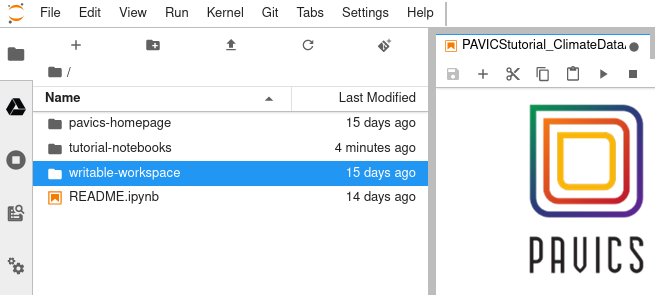

*[return to top of page](#top)*